<a href="https://colab.research.google.com/github/GerardoMunoz/Vision/blob/main/Grad_CAM_salon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM

## Fórmula de Grad-CAM

La salida de Grad-CAM para una clase \( c \) se define como:

$$
L^{c}_{\text{Grad-CAM}} = \text{ReLU}\left( \sum_k \alpha_k^{c} A^k \right)
$$

donde:

$$
\alpha_k^{c} = \frac{1}{Z} \sum_{i,j} \frac{\partial y^c}{\partial A_{ij}^k}
$$

- $ A^k $: mapa de activación del canal $ k $ en la capa convolucional elegida.  
- $ y^c $: puntuación (logit) de la clase $ c $.  
- $ \alpha_k^{c} $: peso que mide la importancia del canal $ k $ para la clase $ c $.  
- $ Z = H \times W $: número total de posiciones espaciales en el mapa.  
- $ i, j $: coordenadas espaciales del mapa de activaciones.  
- ReLU: función que conserva solo las regiones que contribuyen positivamente a la clase $ c $.


In [ ]:
!git clone https://github.com/Gerardo-cursos/objetos_salon

Cloning into 'objetos_salon'...
remote: Enumerating objects: 2511, done.
remote: Counting objects: 100% (659/659), done.
remote: Compressing objects: 100% (508/508), done.
remote: Total 2511 (delta 200), reused 382 (delta 150), pack-reused 1852 (from 5)
Receiving objects: 100% (2511/2511), 1.24 GiB | 21.43 MiB/s, done.
Resolving deltas: 100% (461/461), done.
Updating files: 100% (1727/1727), done.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


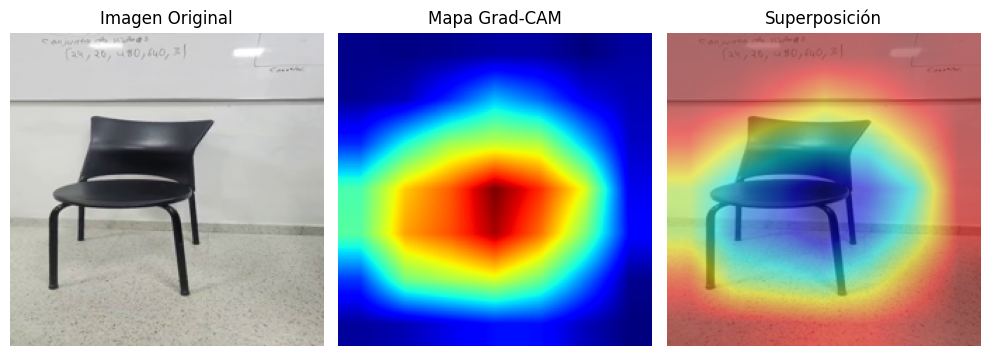

In [ ]:
# ========================================
# Grad-CAM Visualización - PyTorch
# ========================================

import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ---------------------------
# 1. Cargar modelo y capa objetivo
# ---------------------------
model = models.resnet50(pretrained=True)
model.eval()

# La última capa convolucional de ResNet50
target_layer = model.layer4[-1]

# ---------------------------
# 2. Funciones auxiliares
# ---------------------------
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path).convert('RGB')
    tensor = transform(image).unsqueeze(0)
    return tensor, image

# Hook para obtener activaciones y gradientes
activations = None
grads = None

def forward_hook(module, input, output):
    global activations
    activations = output.detach()

def backward_hook(module, grad_input, grad_output):
    global grads
    grads = grad_output[0].detach()

# Registrar hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# ---------------------------
# 3. Cargar imagen y hacer inferencia
# ---------------------------
img_path = "/content/objetos_salon/processed/silla/20251595001_silla_0002.png"  # ← Cambia por tu ruta
input_tensor, orig_img = preprocess_image(img_path)

output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Calcular gradientes respecto a la clase predicha
model.zero_grad()
output[0, pred_class].backward()

# ---------------------------
# 4. Calcular Grad-CAM
# ---------------------------
weights = grads.mean(dim=[2, 3], keepdim=True)
cam = (weights * activations).sum(dim=1, keepdim=True)
cam = F.relu(cam)

# Normalizar entre 0 y 1
cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
cam = cam.squeeze().numpy()
cam = (cam - cam.min()) / (cam.max() - cam.min())

# ---------------------------
# 5. Superponer sobre la imagen original
# ---------------------------
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
orig = np.array(orig_img.resize((224, 224))) / 255
superimposed = 0.5 * heatmap + 0.5 * orig
superimposed = np.clip(superimposed, 0, 1)

# ---------------------------
# 6. Mostrar resultado
# ---------------------------
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("Imagen Original")
plt.imshow(orig)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Mapa Grad-CAM")
plt.imshow(cam, cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Superposición")
plt.imshow(superimposed)
plt.axis('off')

plt.tight_layout()
plt.show()


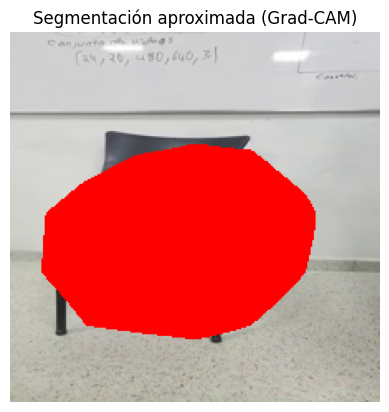

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# cam: tu mapa Grad-CAM ya normalizado en [0,1]

# 1️⃣ Binarizar usando un umbral
threshold = 0.5  # ajusta según el caso
mask = np.uint8(cam > threshold)

# 2️⃣ Opcional: limpieza morfológica
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((5,5),np.uint8))

# 3️⃣ Superponer sobre la imagen original
overlay = orig.copy()
overlay[mask == 1] = (255, 0, 0)  # píxeles segmentados en rojo

plt.imshow(overlay)
plt.title("Segmentación aproximada (Grad-CAM)")
plt.axis('off')
plt.show()


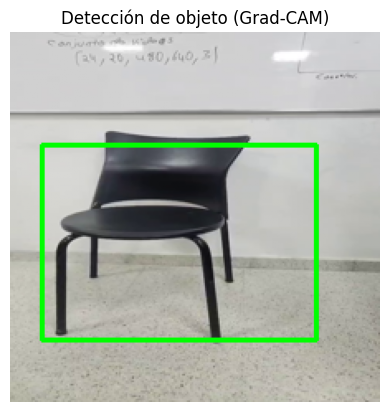

In [ ]:
# 1️⃣ Encuentra contornos en la máscara
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 2️⃣ Genera bounding boxes
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(orig, (x, y), (x+w, y+h), (0,255,0), 2)

plt.imshow(orig)
plt.title("Detección de objeto (Grad-CAM)")
plt.axis('off')
plt.show()
